In [ ]:
    # !pip install hopsworks
    import hopsworks
    import pandas as pd
    # from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
HOPSWORKS_API_KEY = '2LhqnvlunnGDyQaw.rntJAZSmROmOeJCSfQQEESqKIaSjeovrEFPUFuOx2J6Eg6Vx0QuWPnqdv4dWgqvT'
project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Multiple projects found. 

	 (1) iris1337
	 (2) marcusco

Enter project to access: marcusco
Invalid input, should be an integer from the list of projects.

Enter project to access: 2

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/217236
Connected. Call `.close()` to terminate connection gracefully.


In [ ]:
project.hostname

In [ ]:
# The feature view is the input set of features for your model. The features can come from different feature groups.
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query
                                #   ,transformation_functions={
                                # "amount": fs.get_transformation_function(name="standard_scaler", version=1)
                                )

In [ ]:
def process_x_data(data):
    # white -> 0, red -> 1
    type_patterns = [(data['type'] == 'white', 0), (data['type'] == 'red', 1)]
    criteria, values = zip(*type_patterns)
    data['type'] = np.select(criteria, values, 'other')
    print(data['type'][0:10])

In [ ]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

process_x_data(X_train)
process_x_data(X_test)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.23s) 


0     0
2     0
3     0
4     0
6     1
7     1
8     0
10    0
11    1
12    0
Name: type, dtype: object
1     0
5     0
9     0
25    0
29    1
31    0
32    1
48    0
54    0
55    1
Name: type, dtype: object


HistGradientBoostingRegressor()

In [ ]:
# X_train

In [ ]:
# y_train

In [ ]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = np.round(model.predict(X_test))

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)


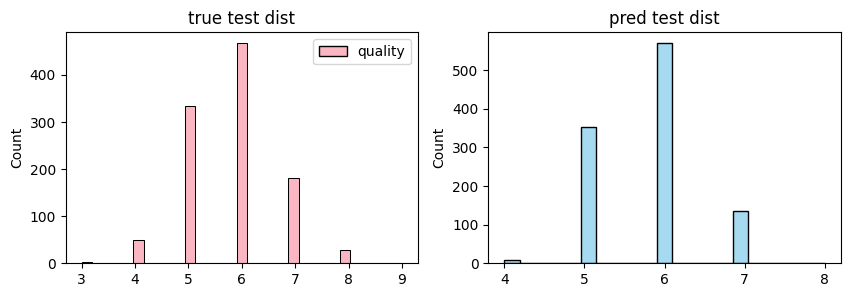

In [ ]:
# histograms of predictions
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.histplot(data=y_test, color='skyblue', ax=axes[0]).set(title='true test dist')
sns.histplot(data=y_pred, color='skyblue', ax=axes[1]).set(title='pred test dist')
plt.show();

In [ ]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 50}, '5': {'precision': 0.6005665722379604, 'recall': 0.6347305389221557, 'f1-score': 0.6171761280931587, 'support': 334}, '6': {'precision': 0.5729349736379613, 'recall': 0.6980728051391863, 'f1-score': 0.6293436293436293, 'support': 467}, '7': {'precision': 0.5037037037037037, 'recall': 0.37362637362637363, 'f1-score': 0.42902208201892744, 'support': 182}, '8': {'precision': 1.0, 'recall': 0.034482758620689655, 'f1-score': 0.06666666666666667, 'support': 29}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.5694183864915572, 'macro avg': {'precision': 0.3824578927970893, 'recall': 0.2487017823297722, 'f1-score': 0.2488869294460546, 'support': 1066}, 'weighted avg': {'precision': 0.5523676753194002, 'recall': 0.5694183864915572, 'f1-score': 0.5441422644909644, 'support': 1066}}


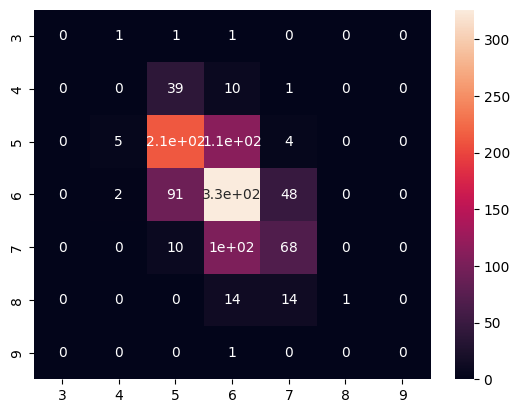

In [ ]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, list(np.arange(3, 10)), list(np.arange(3, 10)))
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [ ]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/17763 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/353856 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1067 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/217236/models/wine_model/1


Model(name: 'wine_model', version: 1)